# Shallow Water Equation

This is a validation of the implementation of the Shallow Water Equations (SWE) or Saint Venant eqations.
This implementation follows: Gunawan, P.H., Eymard, R. & Pudjaprasetya, S.R. Staggered scheme for the Exner–shallow water equations. Comput Geosci 19, 1197–1206 (2015). https://doi.org/10.1007/s10596-015-9533-4

$\partial_t h + \partial_x (h u) = 0$

$\partial_t (h u) + \partial_x \left( h u^2 + \frac{1}{2} g h^2 \right) + g h \partial_x H = 0 $

The following piece of code solves the Saint Venant equations on a staggered grid with explicit time marching.
The simulation data are saved as .png images and subsequently collected as a .gif.

In [1]:
%reset -f
%load_ext autoreload
%autoreload 2

import numpy as np
import Manager as Odin
import matplotlib.pyplot as plt
import imageio
import math

def seaBed(x,L,A,O,phi):
    return O+ A*np.sin(2*math.pi*(x/L - phi) )

domainSize = 10        #m
cellsPerLength = 50
g = 9.81              # m2/s
dt = 0.001              # s
endTime = 5

geom = Odin.createGeometry( 'rectangle', [domainSize, domainSize/cellsPerLength] )
mesh = Odin.createMesh( geom, res=cellsPerLength/domainSize )

flowModels = {
    'h' : Odin.TransportModels.scalarTransport,
    'u' : Odin.TransportModelsSWE.staggeredTransport_u,
    'v' : Odin.TransportModels.staggeredTransport_v
}

closure = {
    'u' : ['v','h'],
    'v' : ['u','h'],
    'h' : ['u','v'],
}

Odin.initialize(flowModels, mesh, geom, closure=closure )

u=Odin.getField('u')
v=Odin.getField('v')
h=Odin.getField('h')

sb = np.array([[seaBed(x,domainSize,0.05, 0.8, 0.15) for x in np.linspace(0, domainSize, cellsPerLength) ]])

u.govModel.setGravitation(g)
u.govModel.setSeaBed(sb)

h.govModel.setDiffusionCoefficient(0)
h.govModel.setHeatCapacity(1)

h.data = np.ones(h.data.shape)-sb

size = 14
for i in range(size):
    h.data[0][2+i:3+i] += 0.05*(1+math.sin((math.pi/size*i*2 - math.pi/2)))
Odin.defineBoundaryCondition(field=h, boundaryName='top', type='zeroGradient' )
Odin.defineBoundaryCondition(field=h, boundaryName='bottom', type='zeroGradient' )
Odin.defineBoundaryCondition(field=h, boundaryName='left', type='zeroGradient')
Odin.defineBoundaryCondition(field=h, boundaryName='right', type='zeroGradient' )

u.data.fill(0.0)
Odin.defineBoundaryCondition(field=u, boundaryName='top', type='zeroGradient')
Odin.defineBoundaryCondition(field=u, boundaryName='bottom', type='zeroGradient' )
Odin.defineBoundaryCondition(field=u, boundaryName='right', type='fixedValue', value=0 )
Odin.defineBoundaryCondition(field=u, boundaryName='left', type='fixedValue', value=0)

In [2]:
# initiating time loop:
currentTime = 0
counter = 0
h_data = [np.insert(h.data, 0, currentTime)]
u_data = [np.insert(u.data, 0, currentTime)]

while currentTime <= endTime:

    if counter%10==0:
        print(f"iter = {counter}\t"
              f"current time = {currentTime:.2e}\t"
              f"time step = {dt:.2e}\t"
              f"||u|| = {np.linalg.norm(u.data):.2e} \t"
              f"||h|| = {np.linalg.norm(h.data):.2e}" )

    currentTime += dt
    counter += 1

    h.data = Odin.transientSolve(h, dt, method='explicit')
    u.data = Odin.transientSolve(u, dt, method='semi-implicit')

    h_data = np.concatenate((h_data, [np.insert(h.data, 0, currentTime)]))
    u_data = np.concatenate((u_data, [np.insert(u.data, 0, currentTime)]))

    dt = u.govModel.calcTimeStep()
print("end of time loop")

iter = 0	current time = 0.00e+00	time step = 1.00e-03	||u|| = 0.00e+00 	||h|| = 1.55e+00
iter = 10	current time = 4.98e-01	time step = 5.22e-02	||u|| = 9.90e-01 	||h|| = 1.54e+00
iter = 20	current time = 1.02e+00	time step = 5.46e-02	||u|| = 8.88e-01 	||h|| = 1.55e+00
iter = 30	current time = 1.55e+00	time step = 5.15e-02	||u|| = 9.97e-01 	||h|| = 1.54e+00
iter = 40	current time = 2.07e+00	time step = 5.14e-02	||u|| = 1.12e+00 	||h|| = 1.54e+00
iter = 50	current time = 2.57e+00	time step = 4.93e-02	||u|| = 1.16e+00 	||h|| = 1.54e+00
iter = 60	current time = 3.06e+00	time step = 4.73e-02	||u|| = 1.20e+00 	||h|| = 1.54e+00
iter = 70	current time = 3.52e+00	time step = 4.56e-02	||u|| = 1.24e+00 	||h|| = 1.54e+00
iter = 80	current time = 3.98e+00	time step = 4.45e-02	||u|| = 1.27e+00 	||h|| = 1.55e+00
iter = 90	current time = 4.42e+00	time step = 4.40e-02	||u|| = 1.29e+00 	||h|| = 1.55e+00
iter = 100	current time = 4.86e+00	time step = 4.61e-02	||u|| = 1.08e+00 	||h|| = 1.56e+00
end of tim

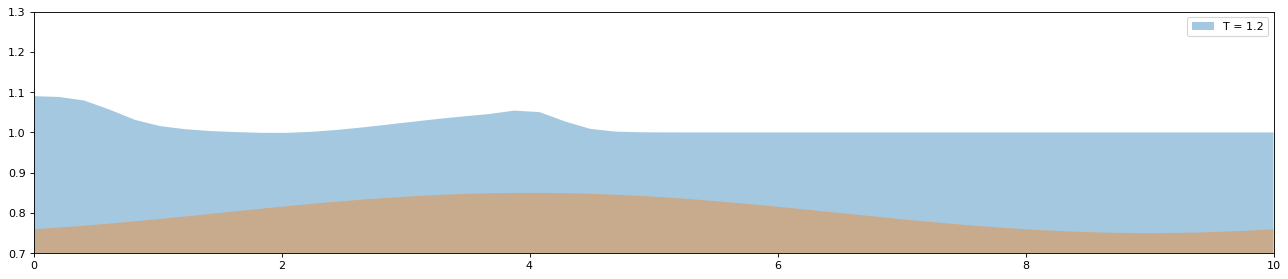

In [3]:
for i,hdat in enumerate(h_data):
    plt.figure(figsize=(20, 4), dpi=80)
    ax = plt.gca()
    #plt.plot(np.linspace(0, domainSize, cellsPerLength), sb[0]+hdat[1:], 'x', label=hdat[0])
    plt.fill_between(np.linspace(0, domainSize, cellsPerLength), sb[0]+hdat[1:], alpha=0.4, label=f"T = {hdat[0]:.2}")
    plt.fill_between(np.linspace(0, domainSize, cellsPerLength), sb[0], alpha=0.4)
    ax.set_ylim([0.7, 1.3])
    ax.set_xlim([0, domainSize])
    plt.legend()
    if i == 24:
        plt.show()

    plt.savefig(f'/home/fynne/temp/img/hdat_{i}.png',
                transparent=False,
                facecolor='white'
                )
    plt.close()

In [ ]:
#Exporting as gif:

frames = []
for i, hdat in enumerate(h_data):
    image = imageio.v2.imread(f'/home/fynne/temp/img/hdat_{i}.png')
    frames.append(image)

imageio.mimsave('/home/fynne/temp/gif/waves.gif',  # output gif
                frames,  # array of input frames
                fps=20)  # optional: frames per second

#
# for udat in u_data:
#     plt.plot(np.linspace(0, domainSize, cellsPerLength+1), udat[1:], 'o-', label=udat[0])


#plt.legend()

#Odin.display(u,mesh,'u')
#Odin.display(h,mesh,'h')

In [ ]:
# shutting the interpreter down, so I can a fresh instance next time.
# my modules are automatically checked for updates
import os
os._exit(00)